In [1]:
# 경고창 무시
import warnings
warnings.filterwarnings('ignore')

## 피클 불러오기

In [2]:
jh_pickle = 'svc_best_model_jh.pkl'
sc_pickle = 'svc_best_model_sc.pkl'
mj_pickle = 'svc_best_model_mj.pkl'

import pickle
with open(jh_pickle,'rb') as pickle_file:
  jh_classification_model = pickle.load(pickle_file)
with open(sc_pickle,'rb') as pickle_file:
  sc_classification_model = pickle.load(pickle_file)
with open(mj_pickle,'rb') as pickle_file:
  mj_classification_model = pickle.load(pickle_file)

## 데이터 불러오기

In [3]:
import pandas as pd
import pymongo
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font', family='NanumBarunGothic') # 혹은 다른 설치한 Nanum 폰트 사용
import scipy
import scipy.stats as stats
from konlpy.tag import Okt
okt = Okt()
from mecab import MeCab
mecab = MeCab()
import pyLDAvis
import pyLDAvis.lda_model
     
client=pymongo.MongoClient("192.168.10.240",27017)
db= client['AI_LKJ']
collection_tour = db['tour_contents']
collection_tour_train = db['data_tour_NLP_train']
data_tour = collection_tour.find()
data_tour_train = collection_tour_train.find()
df_tour = pd.DataFrame(data_tour)
df_tour_train = pd.DataFrame(data_tour_train)
df_tour

,_id,review_text,지역
0,65ee5e2b901db79521bc8779,[이벤트] 동트는 강원 취향저격 이벤트! 나에게 딱 맞는 강원 네이처 로드 코스는?,강원
1,65ee5e2b901db79521bc877a,봄 오는 소리 귀 기울이고 겨울 가는 아쉬움 녹이고,강원
2,65ee5e2c901db79521bc877b,하얀 이불 벗고 봄으로 가는 길 태평성대 가져온 봉황 눈앞에,강원
3,65ee5e2c901db79521bc877c,"열흘에 한 번, 고원 마을에 열리는 반짝 세일! 태백 통리장",강원
4,65ee5e2c901db79521bc877d,걸음 걸음 쌓이는 설렘 바다로 가는 오름길,강원
...,...,...,...
49657,65ee9fa9c27eda916fc759b4,집에서 만나는 전국 맛집,제주
49658,65ee9faac27eda916fc759b5,[윈터 바캉스] 10만원으로 떠나는 제주 당일치기,제주
49659,65ee9faac27eda916fc759b6,제주 서귀포층 패류 화석산지,제주
49660,65ee9faac27eda916fc759b7,제주 한림 용암동굴지대,제주


In [4]:
def split(text):
    clean_text = []
    for word in text.split():
        if "기자" not in word:
            clean_text.append(word)
    return " ".join(clean_text)

In [5]:
df_tour.loc[:,'review_text'] = df_tour['review_text'].apply(split)
# df_tour_train.query("review_text_clean.str.contains('사람')")[:50]
df_tour.query("review_text.str.contains('자단')")

,_id,review_text,지역


In [6]:
# 토크나이징 함수 정의
from konlpy.tag import Okt
okt = Okt()
stopwords = ['남해','대전','대전','공주','안동','나주','바퀴','보령','고령','신안','특산','공항','곡성','신상','사람','위치','가지','진도','장동','정리','도미','고창','모음','장성','시작','남원','가격','화순','국립','베스트','오토','레이스','후기','피아','중앙','공모전','태안','성주','봉화','남도','목포','군산','구례','순천','문경','완주','청주','청도','여수','울주군','포구','두기','거리','강진','뉴스','방법','통영','부여','한밭수목원','거제','서쪽','동쪽','양산','하동','포항','진주','우도','서귀포','당신', '대관령','속초','특별자치도', '삼척','영월','원주','화천','고성','양양','춘천','양구','철원','홍천','태백','달성군','구석구석','블로그','여행','여행지','경기','여주','서구','현황', '장생포','양평','가창','남평문씨','파주','영상','소개','지역','명소','요즘','마을','달성','한눈','카드','추천','수성','안산','기회','횡성','문진','발생','코스','현풍','문진','만끽']
def Tokenizer(raw, pos=["Noun"], stopword=stopwords):
    word_list = []
    for word, tag in okt.pos(raw,norm=True,stem=True):
        if len(word) > 1 and tag in pos and word not in stopword:
            if mecab.pos(word)[0][1] in ["NNG"]:
                if word == '화관':
                    word = '문화관'
                word_list.append(word)
    return " ".join(word_list)
    # return [
    #     word for word, tag in okt.pos(
    #         raw, 
    #         norm=True,   # normalize 그랰ㅋㅏ -> 그래ㅋㅋ
    #         stem=True    # stemming 바뀌나->바뀌다
    #         )
    #         if len(word) > 1 and tag in pos and word not in stopword 

    # ]

In [7]:
df_tour.loc[:,'review_text_clean']=df_tour['review_text'].apply(Tokenizer)

## 데이터 분류하기

In [8]:
df_tour_train

,_id,concept,season,review_text,지역,review_text_clean
0,65ee6316a64dee66ed301e2a,0,0,[블로그 울산 남구 아이스팩 전용 수거함 어디에 있을까?,울산,아이스팩 전용 수거
1,65ee670ba64dee66ed303175,5,3,[가을여행] 전주 당일치기 여행 BEST10 (feat. 덕진공원팸투어) /가을 단...,전북,가을 전주 당일치기 진공 투어 가을 단풍
2,65ee6a64c528b55b0ae79e58,4,0,"대전 유성구 관평동 맛집, 감동적인 맛과 가격 '매봉 쌀국수와 소바'",대전,맛집 감동 쌀국수
3,65ee60fc901db79521bc991b,3,0,역사를 따라가는 DMZ 로드,경기,역사 로드
4,65ee664fc528b55b0ae78d7a,5,0,"아브라다카브라라는 주문을 외워보고 싶은, '대전 보라매공원크리스마스 풍경'",대전,주문 보라매 공원 풍경
...,...,...,...,...,...,...
9995,65ee9b78c27eda916fc74ead,5,-,서귀포 추천 여행지 신창풍차해안도로,제주,풍차 해안 도로
9996,65ee66b6901db79521bcb1d6,4,-,"반려견과 함께 하는 커피 한 잔, 광주 애견동반카페 모음.ZIP",광주,반려견 커피 애견 동반
9997,65ee6722a64dee66ed3032ef,1,-,전북 문화공간 - 완주 복합문화지구 누에(Nu-e),전북,문화 공간 복합 문화 지구 누에
9998,65ee6cd5c528b55b0ae7a7b4,5,-,"벚꽃은 갔지만 유채꽃 만발, 서울에서 만나는 남해",서울,벚꽃 유채꽃 만발


In [9]:
df_tour_train.isnull().sum()

_id                    0
concept                0
season                 0
review_text            0
지역                     0
review_text_clean    225
dtype: int64

In [10]:
df_tour_train=df_tour_train.dropna()

In [11]:
df_tour_train.isnull().sum()

_id                  0
concept              0
season               0
review_text          0
지역                   0
review_text_clean    0
dtype: int64

In [12]:
from sklearn.model_selection import train_test_split
df_tour_train_train,df_tour_train_test = train_test_split(df_tour_train,test_size=0.3,random_state=42)
df_tour_train['concept'].unique()

array([0, 5, 4, 3, 1, 2, 6])

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfVectorizer = TfidfVectorizer(tokenizer = Tokenizer, use_idf=True,max_df=0.95,min_df=2,ngram_range=(1,2))
tfidfVectorizer.fit(df_tour_train['review_text_clean'])

TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2),
                tokenizer=<function Tokenizer at 0x7fb3da107740>)

In [14]:
train_feature = tfidfVectorizer.transform(df_tour_train_train['review_text_clean']) # train
train_target = df_tour_train_train['concept'] # test
test_feature = tfidfVectorizer.transform(df_tour_train_test['review_text_clean']) # train
test_target = df_tour_train_test['concept']


In [15]:
df_tour_train

,_id,concept,season,review_text,지역,review_text_clean
0,65ee6316a64dee66ed301e2a,0,0,[블로그 울산 남구 아이스팩 전용 수거함 어디에 있을까?,울산,아이스팩 전용 수거
1,65ee670ba64dee66ed303175,5,3,[가을여행] 전주 당일치기 여행 BEST10 (feat. 덕진공원팸투어) /가을 단...,전북,가을 전주 당일치기 진공 투어 가을 단풍
2,65ee6a64c528b55b0ae79e58,4,0,"대전 유성구 관평동 맛집, 감동적인 맛과 가격 '매봉 쌀국수와 소바'",대전,맛집 감동 쌀국수
3,65ee60fc901db79521bc991b,3,0,역사를 따라가는 DMZ 로드,경기,역사 로드
4,65ee664fc528b55b0ae78d7a,5,0,"아브라다카브라라는 주문을 외워보고 싶은, '대전 보라매공원크리스마스 풍경'",대전,주문 보라매 공원 풍경
...,...,...,...,...,...,...
9995,65ee9b78c27eda916fc74ead,5,-,서귀포 추천 여행지 신창풍차해안도로,제주,풍차 해안 도로
9996,65ee66b6901db79521bcb1d6,4,-,"반려견과 함께 하는 커피 한 잔, 광주 애견동반카페 모음.ZIP",광주,반려견 커피 애견 동반
9997,65ee6722a64dee66ed3032ef,1,-,전북 문화공간 - 완주 복합문화지구 누에(Nu-e),전북,문화 공간 복합 문화 지구 누에
9998,65ee6cd5c528b55b0ae7a7b4,5,-,"벚꽃은 갔지만 유채꽃 만발, 서울에서 만나는 남해",서울,벚꽃 유채꽃 만발


## Season 모델 작성
- season_RFC

In [16]:
df_tour_train.query("season != '-'")['season'].unique()

array([0, 3, 4, 1, 2], dtype=object)

In [17]:
df_tour_train_train.query("season != '-'")['review_text_clean']

655           캠핑 구산 해수욕장
178         엄마 학교 신입생 모집
3205      봉유 돼지 짬뽕 전복 짬뽕
800             기념물 이팝나무
92                항공샷 랜선
              ...       
2481         마다 평온 고이 시간
782      벚꽃 폴리스 공원 봄꽃 산책
1723         대비 면역 제철 음식
477     혈관 온라인 건강 캠페인 음식
878       외로움 간직 박물관 비양도
Name: review_text_clean, Length: 2727, dtype: object

In [18]:
season_train_feature = tfidfVectorizer.transform(df_tour_train_train.query("season != '-'")['review_text_clean']) # train
season_train_target = df_tour_train_train.query("season != '-'")['season'].astype('str') # test
season_train_feature_test = tfidfVectorizer.transform(df_tour_train_test.query("season != '-'")['review_text_clean']) # train
season_train_target_test = df_tour_train_test.query("season != '-'")['season'].astype('str') # test

In [19]:
from sklearn.ensemble import RandomForestClassifier
season_RFC=RandomForestClassifier(n_jobs=-1)
season_RFC.fit(season_train_feature,season_train_target)

RandomForestClassifier(n_jobs=-1)

In [20]:
from sklearn.metrics import accuracy_score
season_train_feature_predict = season_RFC.predict(season_train_feature)
accuracy_score(season_train_target, season_train_feature_predict)

0.9996332966629996

In [21]:
from sklearn.metrics import classification_report
print(classification_report(season_train_target, season_train_feature_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2273
           1       1.00      1.00      1.00       104
           2       1.00      0.99      1.00       103
           3       1.00      1.00      1.00       148
           4       1.00      1.00      1.00        99

    accuracy                           1.00      2727
   macro avg       1.00      1.00      1.00      2727
weighted avg       1.00      1.00      1.00      2727



In [22]:
season_test_feature_predict = season_RFC.predict(season_train_feature_test)
accuracy_score(season_train_target_test, season_test_feature_predict)

0.9604043807919124

In [23]:
print(classification_report(season_train_target_test, season_test_feature_predict))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       966
           1       0.97      0.73      0.83        41
           2       0.96      0.85      0.90        52
           3       0.95      0.85      0.90        81
           4       0.93      0.87      0.90        47

    accuracy                           0.96      1187
   macro avg       0.95      0.86      0.90      1187
weighted avg       0.96      0.96      0.96      1187



## Concept 모델 선택하기

### 주현

In [24]:
jh_train_feature = tfidfVectorizer.transform(df_tour_train_train['review_text_clean']) # train
jh_train_target = df_tour_train_train['concept'] # test
jh_test_feature = tfidfVectorizer.transform(df_tour_train_test['review_text_clean']) # train
jh_test_target = df_tour_train_test['concept']


In [25]:
jh_classification_model.fit(jh_train_feature,jh_train_target)

SVC(C=1, degree=2, gamma=0.1, kernel='linear')

In [26]:
jh_train_feature_predict = jh_classification_model.predict(jh_train_feature)

In [27]:
from sklearn.metrics import classification_report
print(classification_report(jh_train_target,jh_train_feature_predict))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      1945
           1       0.90      0.84      0.87      1656
           2       0.95      0.78      0.86       195
           3       0.89      0.76      0.82       325
           4       0.96      0.89      0.92       593
           5       0.89      0.90      0.89      1832
           6       0.84      0.71      0.77       296

    accuracy                           0.87      6842
   macro avg       0.89      0.83      0.86      6842
weighted avg       0.88      0.87      0.87      6842



In [28]:
jh_test_feature_predict = jh_classification_model.predict(jh_test_feature)

In [29]:
from sklearn.metrics import classification_report
print(classification_report(jh_test_target,jh_test_feature_predict))

              precision    recall  f1-score   support

           0       0.71      0.85      0.77       833
           1       0.80      0.72      0.76       729
           2       0.87      0.55      0.67        73
           3       0.79      0.55      0.65       138
           4       0.89      0.75      0.81       232
           5       0.78      0.83      0.80       793
           6       0.70      0.53      0.60       135

    accuracy                           0.77      2933
   macro avg       0.79      0.68      0.72      2933
weighted avg       0.77      0.77      0.76      2933



### 명준

### 석천

In [30]:
sc_train_feature = tfidfVectorizer.transform(df_tour_train_train['review_text_clean']) # train
sc_train_target = df_tour_train_train['concept'] # test
sc_test_feature = tfidfVectorizer.transform(df_tour_train_test['review_text_clean']) # train
sc_test_target = df_tour_train_test['concept']

In [31]:
sc_classification_model.fit(sc_train_feature,sc_train_target)

SVC()

In [32]:
sc_train_feature_predict = sc_classification_model.predict(sc_train_feature)

In [33]:
from sklearn.metrics import classification_report
print(classification_report(sc_train_target,sc_train_feature_predict))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1945
           1       0.95      0.94      0.94      1656
           2       0.99      0.86      0.92       195
           3       0.95      0.86      0.90       325
           4       0.98      0.95      0.97       593
           5       0.95      0.96      0.95      1832
           6       0.95      0.79      0.86       296

    accuracy                           0.94      6842
   macro avg       0.95      0.90      0.93      6842
weighted avg       0.94      0.94      0.94      6842



In [34]:
sc_test_feature_predict = sc_classification_model.predict(sc_test_feature)

In [35]:
from sklearn.metrics import classification_report
print(classification_report(sc_test_target,sc_test_feature_predict))

              precision    recall  f1-score   support

           0       0.68      0.88      0.77       833
           1       0.80      0.72      0.76       729
           2       0.92      0.48      0.63        73
           3       0.82      0.48      0.61       138
           4       0.91      0.69      0.78       232
           5       0.79      0.82      0.80       793
           6       0.75      0.45      0.56       135

    accuracy                           0.76      2933
   macro avg       0.81      0.65      0.70      2933
weighted avg       0.77      0.76      0.76      2933



## 데이터

In [36]:
df_tour

,_id,review_text,지역,review_text_clean
0,65ee5e2b901db79521bc8779,[이벤트] 동트는 강원 취향저격 이벤트! 나에게 딱 맞는 강원 네이처 로드 코스는?,강원,이벤트 취향 저격 이벤트 로드
1,65ee5e2b901db79521bc877a,봄 오는 소리 귀 기울이고 겨울 가는 아쉬움 녹이고,강원,소리 겨울 아쉬움
2,65ee5e2c901db79521bc877b,하얀 이불 벗고 봄으로 가는 길 태평성대 가져온 봉황 눈앞에,강원,이불 태평성대 봉황 눈앞
3,65ee5e2c901db79521bc877c,"열흘에 한 번, 고원 마을에 열리는 반짝 세일! 태백 통리장",강원,열흘 통리
4,65ee5e2c901db79521bc877d,걸음 걸음 쌓이는 설렘 바다로 가는 오름길,강원,걸음 걸음 바다로
...,...,...,...,...
49657,65ee9fa9c27eda916fc759b4,집에서 만나는 전국 맛집,제주,전국 맛집
49658,65ee9faac27eda916fc759b5,[윈터 바캉스] 10만원으로 떠나는 제주 당일치기,제주,바캉스 당일치기
49659,65ee9faac27eda916fc759b6,제주 서귀포층 패류 화석산지,제주,패류 화석 산지
49660,65ee9faac27eda916fc759b7,제주 한림 용암동굴지대,제주,한림 용암동굴 지대


In [37]:
## 컨셉

# 벡터라이징
jh_feature = tfidfVectorizer.transform(df_tour['review_text_clean'])


# 컨셉 예측을 모델 학습
tour_concept_predict = jh_classification_model.predict(jh_feature)
# 예측한값을 concept 컬럼에 추가
df_tour.loc[:,'concept']=tour_concept_predict
# concept열을 jh_target이라고 정의
jh_target_concept = df_tour['concept']
# 모델 학습
jh_classification_model.fit(jh_feature,jh_target_concept)

SVC(C=1, degree=2, gamma=0.1, kernel='linear')

In [38]:
## 계절

# 컨셉 예측을 모델 학습
tour_season_predict = season_RFC.predict(jh_feature)
# 예측한값을 
df_tour.loc[:,'season']=tour_season_predict
# concept열을 jh_target이라고 정의
jh_target_season = df_tour['season']
# 모델 학습
season_RFC.fit(jh_feature,jh_target_season)

RandomForestClassifier(n_jobs=-1)

In [39]:
df_tour

,_id,review_text,지역,review_text_clean,concept,season
0,65ee5e2b901db79521bc8779,[이벤트] 동트는 강원 취향저격 이벤트! 나에게 딱 맞는 강원 네이처 로드 코스는?,강원,이벤트 취향 저격 이벤트 로드,0,0
1,65ee5e2b901db79521bc877a,봄 오는 소리 귀 기울이고 겨울 가는 아쉬움 녹이고,강원,소리 겨울 아쉬움,0,4
2,65ee5e2c901db79521bc877b,하얀 이불 벗고 봄으로 가는 길 태평성대 가져온 봉황 눈앞에,강원,이불 태평성대 봉황 눈앞,0,0
3,65ee5e2c901db79521bc877c,"열흘에 한 번, 고원 마을에 열리는 반짝 세일! 태백 통리장",강원,열흘 통리,0,0
4,65ee5e2c901db79521bc877d,걸음 걸음 쌓이는 설렘 바다로 가는 오름길,강원,걸음 걸음 바다로,0,0
...,...,...,...,...,...,...
49657,65ee9fa9c27eda916fc759b4,집에서 만나는 전국 맛집,제주,전국 맛집,4,0
49658,65ee9faac27eda916fc759b5,[윈터 바캉스] 10만원으로 떠나는 제주 당일치기,제주,바캉스 당일치기,0,0
49659,65ee9faac27eda916fc759b6,제주 서귀포층 패류 화석산지,제주,패류 화석 산지,0,0
49660,65ee9faac27eda916fc759b7,제주 한림 용암동굴지대,제주,한림 용암동굴 지대,5,0


## 데이터 탐색

In [40]:
# 값이 0인값들이 결측값이 아닌 유의미한 value로 인식되는 듯함.

df_tour.isnull().sum()

_id                  0
review_text          0
지역                   0
review_text_clean    0
concept              0
season               0
dtype: int64

In [41]:
# condition collection

concept_nothing = "concept == 0"
concept_culture = "concept == 1"
concept_leisure = "concept == 2"
concept_history = "concept == 3"
concept_food = "concept == 4"
concept_nature = "concept == 5"
concept_healing = "concept == 6"

season_nothing = "season == 0"
season_spring = "season == 1"
season_summer = "season == 2"
season_autumn = "season == 3"
season_winter = "season == 4"

In [42]:
df_tour_concept = df_tour[df_tour["concept"] != 0]

In [43]:
df_tour["season"]=df_tour["season"].astype('int')

In [44]:
df_tour_season = df_tour[df_tour["season"] != 0]

In [45]:
df_tour_concept

,_id,review_text,지역,review_text_clean,concept,season
7,65ee5e2c901db79521bc8780,"와인에 스민 청정자연, 향에 반하고 풍광에 취한다",강원,와인 청정 자연 취한,5,0
9,65ee5e2c901db79521bc8782,하늘에 뿌린 눈꽃 천상의 설원 되다,강원,하늘 눈꽃 천상 설원,5,0
11,65ee5e2d901db79521bc8784,"자연과 인공의 조화, 절벽 위에 핀 누정",강원,자연 인공 조화 절벽 누정,5,0
21,65ee5e2e901db79521bc878e,겨울 강원도여행 대관령 삼양라운드힐 설경 눈구경 가볼만한곳 삼양목장,강원,겨울 설경 구경 목장,5,4
23,65ee5e2e901db79521bc8790,강원도 겨울 축제 홍천 평창 화천 가볼만한곳 얼음 낚시 체험 가볼만한곳,강원,겨울 축제 얼음 낚시 체험,1,4
...,...,...,...,...,...,...
49651,65ee9fa7c27eda916fc759ae,정방폭포 제주도 가볼만한 곳 제주여행,제주,정방폭포,5,0
49652,65ee9fa7c27eda916fc759af,[제주맛집] 먹방! 제주쇠소깍 오메기식당,제주,맛집 먹방 식당,4,0
49654,65ee9fa8c27eda916fc759b1,제주시 오라동 유채꽃밭 (오라동 메밀꽃밭),제주,유채꽃 메밀 꽃밭,5,1
49657,65ee9fa9c27eda916fc759b4,집에서 만나는 전국 맛집,제주,전국 맛집,4,0


In [46]:
# concept 를 텍스트화 
df_tour_concept['concept_name'] = df_tour_concept['concept'].map({1: '문화', 2: '레져', 3: '역사', 4: '음식',  5: '자연',  6: '힐링'})
df_tour_concept

,_id,review_text,지역,review_text_clean,concept,season,concept_name
7,65ee5e2c901db79521bc8780,"와인에 스민 청정자연, 향에 반하고 풍광에 취한다",강원,와인 청정 자연 취한,5,0,자연
9,65ee5e2c901db79521bc8782,하늘에 뿌린 눈꽃 천상의 설원 되다,강원,하늘 눈꽃 천상 설원,5,0,자연
11,65ee5e2d901db79521bc8784,"자연과 인공의 조화, 절벽 위에 핀 누정",강원,자연 인공 조화 절벽 누정,5,0,자연
21,65ee5e2e901db79521bc878e,겨울 강원도여행 대관령 삼양라운드힐 설경 눈구경 가볼만한곳 삼양목장,강원,겨울 설경 구경 목장,5,4,자연
23,65ee5e2e901db79521bc8790,강원도 겨울 축제 홍천 평창 화천 가볼만한곳 얼음 낚시 체험 가볼만한곳,강원,겨울 축제 얼음 낚시 체험,1,4,문화
...,...,...,...,...,...,...,...
49651,65ee9fa7c27eda916fc759ae,정방폭포 제주도 가볼만한 곳 제주여행,제주,정방폭포,5,0,자연
49652,65ee9fa7c27eda916fc759af,[제주맛집] 먹방! 제주쇠소깍 오메기식당,제주,맛집 먹방 식당,4,0,음식
49654,65ee9fa8c27eda916fc759b1,제주시 오라동 유채꽃밭 (오라동 메밀꽃밭),제주,유채꽃 메밀 꽃밭,5,1,자연
49657,65ee9fa9c27eda916fc759b4,집에서 만나는 전국 맛집,제주,전국 맛집,4,0,음식


In [47]:
# season 을 텍스트화
df_tour_season['season_name'] = df_tour_season['season'].map({1: '봄', 2: '여름', 3: '가을', 4: '겨울'})
df_tour_season

,_id,review_text,지역,review_text_clean,concept,season,season_name
1,65ee5e2b901db79521bc877a,봄 오는 소리 귀 기울이고 겨울 가는 아쉬움 녹이고,강원,소리 겨울 아쉬움,0,4,겨울
5,65ee5e2c901db79521bc877e,겨울이 지나 봄이 올 때 강릉 나들이 다녀오기,강원,겨울,0,4,겨울
13,65ee5e2d901db79521bc8786,"딱 열흘간 열리는 겨울왕국, 영원히 남을 순백의 추억",강원,열흘 겨울왕국 순백 추억,0,4,겨울
18,65ee5e2d901db79521bc878b,국내 여행지 추천 강원도 1박2일 여행코스 겨울 속초 가볼만한곳,강원,국내 겨울,0,4,겨울
19,65ee5e2e901db79521bc878c,겨울이 선사한 은빛 무대 마음껏 춤을 춰봐,강원,겨울 선사 은빛 무대,0,4,겨울
...,...,...,...,...,...,...,...
49606,65ee9f97c27eda916fc75981,제주공항근처 즐길거리 정보 한여름밤의 축제도 열린다고 해요,제주,근처 길거리 정보 여름밤 축제,1,2,여름
49613,65ee9f9ac27eda916fc75988,여름휴가 시원한 제주도 여행지 모음 여기는 꼭 가봐야해 !,제주,여름 휴가,6,2,여름
49619,65ee9f9cc27eda916fc7598e,제주도 여름휴가 시원한 맥주 마시기 좋은 표선맛집 저녁먹기에도 GooD,제주,여름 휴가 맥주 표선 맛집 저녁,4,2,여름
49628,65ee9f9fc27eda916fc75997,성수기 제주도여행 여름휴가때 꼭 먹어봐야할 자연산 다금바리 맛집,제주,수기 여름 휴가 자연 다금바리 맛집,5,2,여름


## 데이터 분석

### 1. 유형별 빈도수
- 접근 : 어느 유형의 여행이 많을지 파악
- 결과 : 자연 > 문화 > 음식 > 힐링 > 역사 > 레져

In [56]:
value_culture = df_tour_concept.query("concept_name == '문화'").value_counts().sum()
value_leisure = df_tour_concept.query("concept_name == '레져'").value_counts().sum()
value_history = df_tour_concept.query("concept_name == '역사'").value_counts().sum()
value_food = df_tour_concept.query("concept_name == '음식'").value_counts().sum()
value_nature = df_tour_concept.query("concept_name == '자연'").value_counts().sum()
value_healing = df_tour_concept.query("concept_name == '힐링'").value_counts().sum()

In [70]:
df_value_concept = pd.DataFrame({'concept_name': ['문화', '레져', '역사', '음식', '자연', '힐링'],'value': [value_culture, value_leisure, value_history, value_food, value_nature, value_healing]})
df_value_concept

,concept_name,value
0,문화,10973
1,레져,922
2,역사,1759
3,음식,3490
4,자연,13190
5,힐링,1775


<Axes: xlabel='concept_name', ylabel='value'>

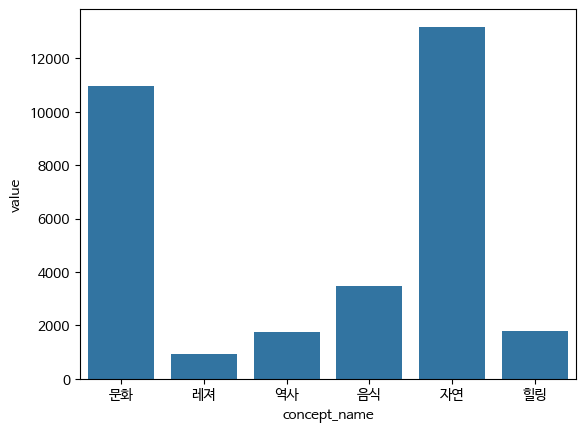

In [64]:
sns.barplot(data=df_value_concept , x = "concept_name", y = "value")

### 2. 계절별 빈도수
- 접근 : 어느 계절에 여행이 많을지 파악
- 결과 : 가을 > 겨울 > 여름 > 봄

In [81]:
value_spring = df_tour_season.query("season_name == '봄'").value_counts().sum()
value_summer = df_tour_season.query("season_name == '여름'").value_counts().sum()
value_autumn = df_tour_season.query("season_name == '가을'").value_counts().sum()
value_winter = df_tour_season.query("season_name == '겨울'").value_counts().sum()

In [82]:
df_value_season = pd.DataFrame({'season_name': ['봄', '여름', '가을', '겨울'], 'value': [value_spring, value_summer, value_autumn, value_winter]})
df_value_season

,season_name,value
0,봄,1574
1,여름,1579
2,가을,2419
3,겨울,1600


<Axes: xlabel='season_name', ylabel='value'>

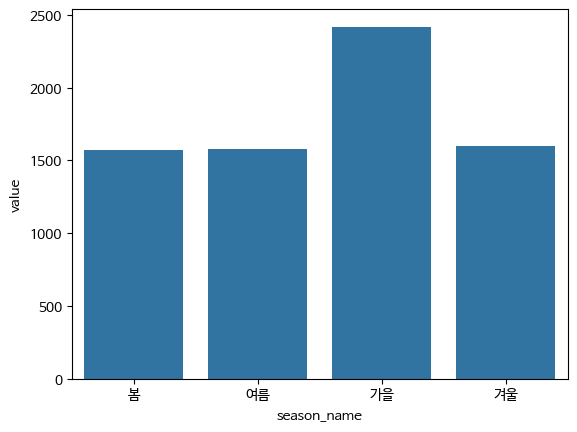

In [83]:
sns.barplot(data=df_value_season , x = "season_name", y = "value")

### 3. 유형과 계절의 관계성
- 접근 : 어떤 계절에 어떤 유형의 여행이 많은지를 파악

#### (1) 봄
- 결과 : 자연 > 문화 > 힐링 > 레져 > 음식 > 역사

In [136]:
spring_culture = df_tour_season.query("season_name == '봄'").query("concept == 1").value_counts().sum()
spring_leisure = df_tour_season.query("season_name == '봄'").query("concept == 2").value_counts().sum()
spring_history = df_tour_season.query("season_name == '봄'").query("concept == 3").value_counts().sum()
spring_food = df_tour_season.query("season_name == '봄'").query("concept == 4").value_counts().sum()
spring_nature = df_tour_season.query("season_name == '봄'").query("concept == 5").value_counts().sum()
spring_healing = df_tour_season.query("season_name == '봄'").query("concept == 6").value_counts().sum()

In [139]:
df_spring = pd.DataFrame({'concept' : ["문화","레져","역사","음식","자연","힐링"], 'value': [spring_culture,spring_leisure,spring_history,spring_food,spring_nature,spring_healing]})
df_spring

,concept,value
0,문화,178
1,레져,33
2,역사,19
3,음식,27
4,자연,1181
5,힐링,40


<Axes: xlabel='concept', ylabel='value'>

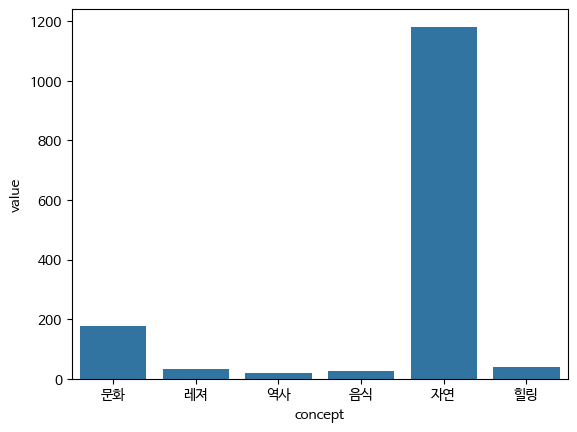

In [141]:
sns.barplot(data=df_spring, x="concept", y="value")

#### (2) 여름
- 결과 : 자연 > 문화 > 힐링 > 음식 > 레져 > 역사

In [144]:
summer_culture = df_tour_season.query("season_name == '여름'").query("concept == 1").value_counts().sum()
summer_leisure = df_tour_season.query("season_name == '여름'").query("concept == 2").value_counts().sum()
summer_history = df_tour_season.query("season_name == '여름'").query("concept == 3").value_counts().sum()
summer_food = df_tour_season.query("season_name == '여름'").query("concept == 4").value_counts().sum()
summer_nature = df_tour_season.query("season_name == '여름'").query("concept == 5").value_counts().sum()
summer_healing = df_tour_season.query("season_name == '여름'").query("concept == 6").value_counts().sum()

In [145]:
df_summer = pd.DataFrame({'concept' : ["문화","레져","역사","음식","자연","힐링"], 'value': [summer_culture,summer_leisure,summer_history,summer_food,summer_nature,summer_healing]})
df_summer

,concept,value
0,문화,257
1,레져,43
2,역사,18
3,음식,81
4,자연,591
5,힐링,117


<Axes: xlabel='concept', ylabel='value'>

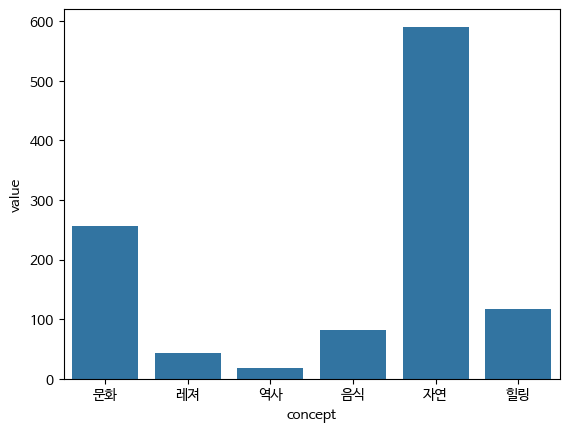

In [146]:
sns.barplot(data=df_summer, x="concept", y="value")

#### (3) 가을
- 결과 : 자연 > 문화 > 힐링 > 레져 > 음식 > 역사

In [147]:
autumn_culture = df_tour_season.query("season_name == '가을'").query("concept == 1").value_counts().sum()
autumn_leisure = df_tour_season.query("season_name == '가을'").query("concept == 2").value_counts().sum()
autumn_history = df_tour_season.query("season_name == '가을'").query("concept == 3").value_counts().sum()
autumn_food = df_tour_season.query("season_name == '가을'").query("concept == 4").value_counts().sum()
autumn_nature = df_tour_season.query("season_name == '가을'").query("concept == 5").value_counts().sum()
autumn_healing = df_tour_season.query("season_name == '가을'").query("concept == 6").value_counts().sum()

In [148]:
df_autumn = pd.DataFrame({'concept' : ["문화","레져","역사","음식","자연","힐링"], 'value': [autumn_culture,autumn_leisure,autumn_history,autumn_food,autumn_nature,autumn_healing]})
df_autumn

,concept,value
0,문화,302
1,레져,83
2,역사,18
3,음식,49
4,자연,1270
5,힐링,122


<Axes: xlabel='concept', ylabel='value'>

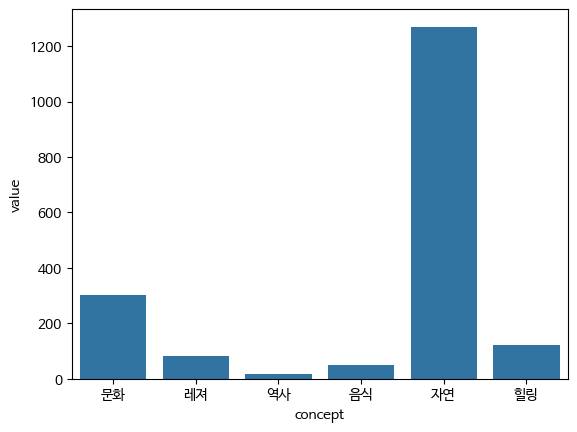

In [149]:
sns.barplot(data=df_autumn, x="concept", y="value")

#### (4) 겨울
- 결과 : 자연 > 문화 > 힐링 > 음식 > 레져	 > 역사

In [150]:
winter_culture = df_tour_season.query("season_name == '겨울'").query("concept == 1").value_counts().sum()
winter_leisure = df_tour_season.query("season_name == '겨울'").query("concept == 2").value_counts().sum()
winter_history = df_tour_season.query("season_name == '겨울'").query("concept == 3").value_counts().sum()
winter_food = df_tour_season.query("season_name == '겨울'").query("concept == 4").value_counts().sum()
winter_nature = df_tour_season.query("season_name == '겨울'").query("concept == 5").value_counts().sum()
winter_healing = df_tour_season.query("season_name == '겨울'").query("concept == 6").value_counts().sum()

In [151]:
df_winter = pd.DataFrame({'concept' : ["문화","레져","역사","음식","자연","힐링"], 'value': [winter_culture,winter_leisure,winter_history,winter_food,winter_nature,winter_healing]})
df_winter

,concept,value
0,문화,335
1,레져,38
2,역사,23
3,음식,89
4,자연,578
5,힐링,49


<Axes: xlabel='concept', ylabel='value'>

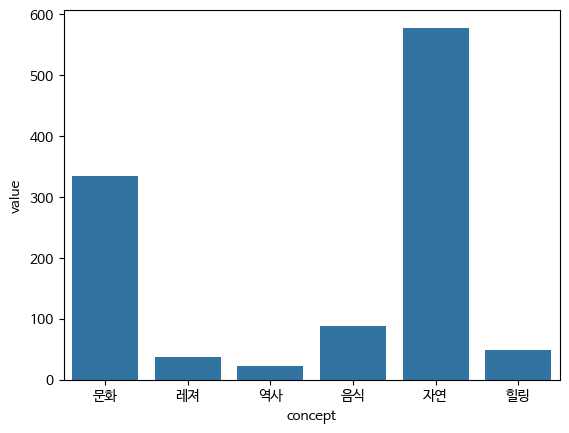

In [152]:
sns.barplot(data=df_winter, x="concept", y="value")

## 인사이트
- 전체적으로 봤을때 주로 개최하는 여행 유형은 [자연]과 [문화] 인 것을 알 수 있다.
  + 자연,문화를 위주로 여행지 추천 또는 관련 아이템 구매 유도
- 봄,여름,겨울의 여행량은 비슷한 반면 가을에 여행이 훨씬 많은 모습을 보인다.
    + 다양한 가을 여행들을 소개
- 계절별로 자연,문화가 압도적인 수치를 보이며 이외에는 대체적으로 상당히 저조한 모습을 보인다.
    + 자연,문화를 위주로 소개